# Evaluating SqueezeNet 1.1 trained to detect defects in steel sheet 

### 1. Requirments

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

### 2. Parameters

In [7]:
MODEL_PATH = '../model/BinarySqueeze.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/binaryData'
METADATA_PATH = '../data/binaryData/val_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_val_binary.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_val_binary.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_val_binary.pth'

In [8]:
N_CLASSES = 2
params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

### 3. Data
#### 3.1 Load data
Since retrieving all the batches using dataloader has been quite slow and created problem in Colab, a procedure to generate the full torch matrix (input, labels and masks) from the images should be performed to run this jupyter smoothly. If the INPUT, MASK and LABEL matrix are already present in the given paths we just load them

In [9]:
### Check if the given paths exists
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]): # Create folder if it does not exists
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [10]:
### If the path are present we load the matrix, else we generate them
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_val, y_val, M_val = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                              batch_size=200, num_workers=0, 
                                              return_mask=True, params=params)

Data is present and ready to be loaded


#### 3.2 Visualize data

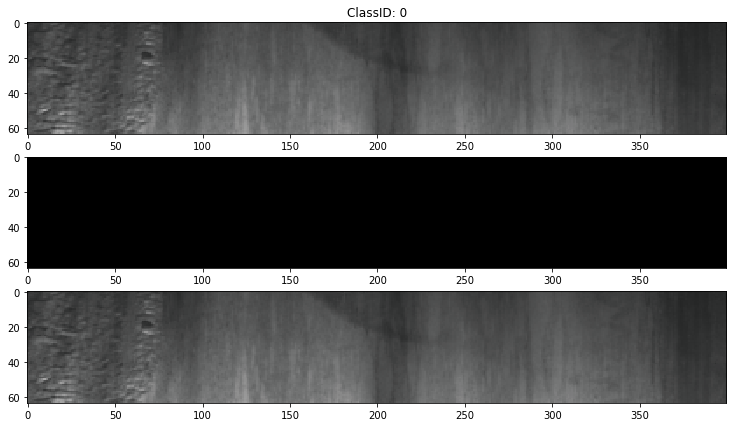

In [11]:
n = 0

fig, ax = plt.subplots(3, 1, figsize=(20, 7))
img = np.transpose(X_val[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
mask = M_val[n].reshape(*params['size'])
ax[0].set_title('ClassID: {}'.format(y_val[n]))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')
img[mask == 1] = img[mask == 1] + params['colors'][y_val[n]]
ax[2].imshow(img)
plt.show()

### 4. Model

    a) Load SqueezeNet architecture
    b) Modify the classifier architecture
    c) Load the parameters
    d) Move model in GPU

In [12]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 2), nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

### 5. Evaluation

    a) Compute the predicted labels and the probabilities of belonging to class 0 (No Defects)
    b) Compute metrics with normal threshold (0.50)
    c) Compute optimal threshold
    d) Plot ROC and Confusion Matrix

In [39]:
y_pred = []
y_true = []
y_score = []
batch_size = 20

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        #probs = nn.Softmax(dim=1)(out).detach().cpu().numpy()
        
        y_score = np.concatenate([y_score, out[:, 0].detach().cpu().numpy()])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 12.91it/s]


In [40]:
tpr, fpr, threshold = roc_curve(y_true, y_score)
auc_score = auc(fpr, tpr)
print('METRICS WITH 0.5 AS THRESHOLD')
print('-----------------------------')
print('Accuracy:\t{:.4f}'.format(accuracy_score(y_true, y_pred)))
print('F1 Score:\t{:.4f}'.format(f1_score(y_true, y_pred, average='macro')))
print('AUC Score:\t{:.4f}'.format(auc_score))

METRICS WITH 0.5 AS THRESHOLD
-----------------------------
Accuracy:	0.9276
F1 Score:	0.9271
AUC Score:	0.9792


In [41]:
def get_treshold(t=0.5):
    y_pred_s = y_score.copy()
    y_pred_s[y_score > t] = 0
    y_pred_s[y_score <= t] = 1 
    return y_pred_s, f1_score(y_true, y_pred_s, average='macro')

best_treshold = np.argmax([get_treshold(t=i)[1] for i in np.arange(0, 1, step=0.05)])*0.05
y_pred_best = get_treshold(t=best_treshold)[0]

accuracy = accuracy_score(y_true, y_pred_best)
f1 = f1_score(y_true, y_pred_best, average='macro')
print('METRICS WITH {:.2f} THRESHOLD'.format(best_treshold))
print('-----------------------------')
print('Accuracy:\t{:.4f}'.format(accuracy))
print('F1 Score:\t{:.4f}'.format(f1))
print('AUC Score:\t{:.4f}'.format(auc_score))

METRICS WITH 0.70 THRESHOLD
-----------------------------
Accuracy:	0.9320
F1 Score:	0.9311
AUC Score:	0.9792


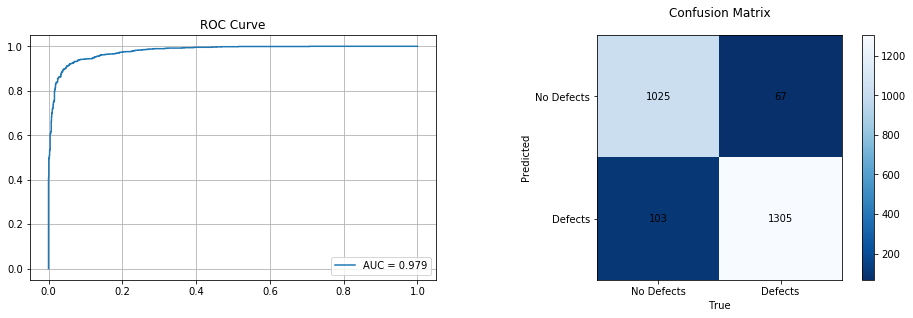

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))

ax[0].plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
ax[0].grid()
ax[0].legend()
ax[0].set_title('ROC Curve')

cm = confusion_matrix(y_pred_best, y_true)
cm_plot = ax[1].matshow(cm, cmap='Blues_r')
ax[1].set_title('Confusion Matrix')
ax[1].set_xlabel('True')
ax[1].set_ylabel('Predicted')
ax[1].xaxis.set_ticks_position('bottom')
plt.colorbar(cm_plot)
ax[1].set_xticklabels(['No Defects', 'No Defects', 'Defects'])
ax[1].set_yticklabels(['No Defects', 'No Defects', 'Defects'])
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        k = 0
        ax[1].text(j, i, cm[i, j], va='center', ha='center')